# Data-to-graph demo

_Ismael Mendoza (UMich) & Alex Malz (CMU)_

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle 

In [2]:
import networkx as nx

## Load data

This notebook shows how to load the mock data from BTK provided in `/data/mock.pkl`

In [3]:
images, true, pred = pickle.load(open('../data/mock.pkl', 'rb'))
images.shape

(100, 6, 120, 120)

`images` is 100 postage stamps, 6 photometric bands, 120x120 pixels each

`true` and `pred` are lists of astropy tables with columns for the `x` and `y` coordinates of the centroids and a `flux` value for each source, one table per postage stamp

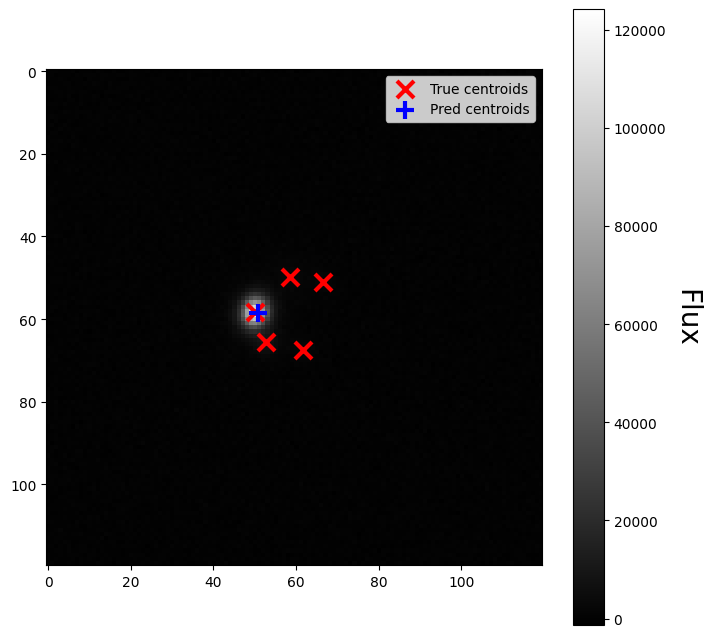

In [4]:
idx = np.random.randint(0, len(images))
band_idx = 2
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.imshow(images[idx,band_idx], cmap='gray')
ax.scatter(
    true[idx]["x"],
    true[idx]["y"],
    color="red",
    marker="x",
    label="True centroids",
    s=150,
    linewidth=3,
)
ax.scatter(
    pred[idx]["x"],
    pred[idx]["y"],
    color="blue",
    marker="+",
    label="Pred centroids",
    s=150,
    linewidth=3,
)

# add colorbar to axis
cbar = fig.colorbar(ax.images[0], ax=ax)
cbar.ax.set_ylabel("Flux", rotation=-90, va="bottom", fontsize=20)

# add legend to axis
ax.legend(loc="upper right")

## interpret one as graph

In [5]:
# true[idx].add_column([str(ind)+'true' for ind in range(len(true[idx]))], index=0, name='index')
# pred[idx].add_column([str(ind)+'pred' for ind in range(len(pred[idx]))], index=0, name='index')

true[idx].add_column([round(np.log10(t['flux']), 2) for t in true[idx]], name='mag')
pred[idx].add_column([round(np.log10(p['flux']), 2) for p in pred[idx]], name='mag')

let's associate a notion of weight with the edges

In [6]:
def get_dist(a, b):
    dx = a['x'] - b['x']
    dy = a['y'] - b['y']
    d = np.sqrt(dx**2 + dy**2)
    return d

In [7]:
edgelist = []
for t in true[idx]:
    for p in pred[idx]:
        edgelist.append((t['mag'], p['mag'], round(1./get_dist(t, p), 3)))

In [8]:
G = nx.Graph()
G.add_nodes_from(true[idx]['mag'], bipartite=0)
G.add_nodes_from(pred[idx]['mag'], bipartite=1)
G.add_weighted_edges_from(edgelist)

In [9]:
G.edges.data('weight')

EdgeDataView([(6.48, 6.46, 1.034), (4.66, 6.46, 0.057), (5.25, 6.46, 0.14), (4.69, 6.46, 0.072), (4.86, 6.46, 0.086)])

In [10]:
nx.bipartite.sets(G)

({4.66, 4.69, 4.86, 5.25, 6.48}, {6.46})

{(6.48, 6.46): Text(-0.1068046604473761, 0.07678859215488122, '1.034'),
 (4.66, 6.46): Text(-0.003569494848840468, 0.4987576406791138, '0.057'),
 (5.25, 6.46): Text(0.3274779703959665, 0.04059983264563844, '0.14'),
 (4.69, 6.46): Text(0.15320231861736266, -0.4207296743430368, '0.072'),
 (4.86, 6.46): Text(-0.3735161764779503, -0.20038582842014135, '0.086')}

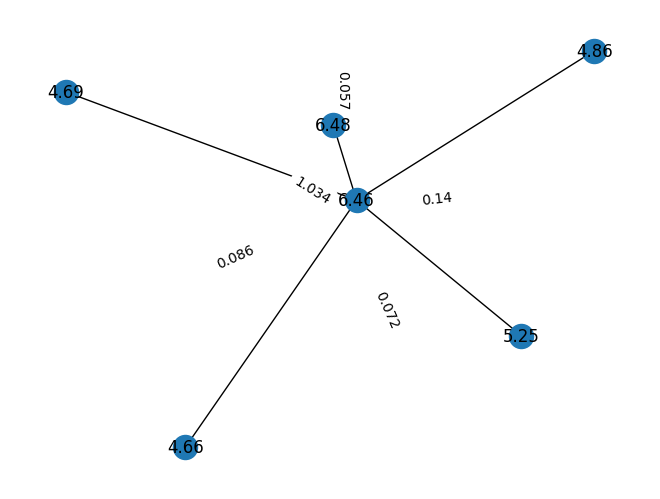

In [11]:
nx.draw(G, with_labels=True)
edge_labels = nx.get_edge_attributes(G, "weight")
pos = nx.spring_layout(G, seed=7)
nx.draw_networkx_edge_labels(G, pos, edge_labels)

## make all into graphs

## explore diagnostics on "real" data